In [1]:
import pandas as pd
import numpy as np 
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv("data.csv")
train_df.head()
len(train_df)

10886

In [3]:
train_df = train_df.drop(columns=["instant", "dteday"])
print(len(train_df))
train_df, val_df = train_test_split(train_df, test_size=0.2)
len(train_df), len(val_df)

10886


(8708, 2178)

In [4]:
train_df.dtypes

season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [5]:
train_df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,2.502412,0.506546,6.507235,11.528939,0.027561,3.011943,0.682361,1.418810,0.494203,0.473784,0.618400,0.190805,36.190514,155.978755,192.169270
std,1.115422,0.499986,3.439656,6.903174,0.163720,2.002604,0.465585,0.633435,0.189537,0.169062,0.191891,0.122016,50.195757,150.863925,180.992981
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.030300,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,4.000000,36.000000,42.000000
50%,2.000000,1.000000,6.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.620000,0.194000,16.500000,119.500000,146.000000
75%,3.000000,1.000000,9.000000,17.000000,0.000000,5.000000,1.000000,2.000000,0.640000,0.621200,0.770000,0.253700,49.000000,223.000000,285.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,0.893900,1.000000,0.850700,367.000000,857.000000,970.000000


In [6]:
class RentalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, y_column: str = "cnt") -> None:
        super().__init__()
        self.X = df.drop(columns=["casual", "cnt", "registered"]).values
        self.y = df[y_column].values
        
    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return torch.tensor(self.X[index], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.y)

## CNT PRED

In [7]:
BATCH_SIZE = 64

In [8]:
cnt_train_dataset = RentalDataset(train_df)
cnt_val_dataset = RentalDataset(val_df)


In [9]:
cnt_train_dataloader = DataLoader(cnt_train_dataset, batch_size=BATCH_SIZE)
cnt_val_dataloader = DataLoader(cnt_val_dataset, batch_size=BATCH_SIZE)

sample = next(iter(cnt_train_dataloader))
sample[0][0].shape, sample[1][0]

(torch.Size([12]), tensor(23.))

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [11]:
class RentalNet(nn.Module):
    def __init__(self, num_layers:int = 2, hidden_dim: int = 512, dropout: float = 0.7):
        super(RentalNet, self).__init__()
        hidden_dim = 512
    
        self.input_layer = nn.Linear(12, hidden_dim)

        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(int(hidden_dim / 2**i), int(hidden_dim / 2**(i+1))),
                nn.BatchNorm1d(int(hidden_dim / 2**(i+1))),
                nn.LeakyReLU(),
                nn.Dropout(dropout)
            ) for i in range(num_layers)
        ])

        self.output_layer = nn.Linear(int(hidden_dim / 2**num_layers), 1)

    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)


In [12]:
from tqdm import tqdm


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: str = "cuda",
) -> dict[str, list[float]]:

    results: dict[str, list[float]] = {
        "Train_RMSLE": [],
        "Val_RMSLE": [],
        "Train_MAE": [],
        "Val_MAE": [],   
        "Train_MSE": [],
        "Val_MSE": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_mae, train_rmsle = train_step(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            device=device,
        )
        val_loss, val_mae, val_rmsle = test_step(
            model=model, val_dataloader=val_dataloader, loss_fn=loss_fn, device=device
        )
        results["Train_RMSLE"].append(train_rmsle)
        results["Val_RMSLE"].append(val_rmsle)
        results["Train_MAE"].append(train_mae)
        results["Val_MAE"].append(val_mae)
        results["Train_MSE"].append(train_loss)
        results["Val_MSE"].append(val_loss)

    return results

def rmsle(predictions, targets):
    return torch.sqrt(torch.mean((torch.log1p(predictions) - torch.log1p(targets)) ** 2))


def train_step(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device="cuda",
) -> tuple[float, float, float]:
    model.train()
    total_loss = 0
    total_mae = 0.0
    total_rmsle = 0.0
    for batch, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_mae += torch.abs(outputs - targets).sum().item()
        total_rmsle += rmsle(outputs, targets).item()
    total_loss /= len(train_dataloader)
    total_mae /= len(train_dataloader.dataset)
    total_rmsle /= len(train_dataloader)
    return total_loss, total_mae, total_rmsle


def test_step(
    model: torch.nn.Module,
    val_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device="cuda",
) -> tuple[float, float, float]:
    model.eval()
    total_loss = 0
    total_mae = 0.0
    total_rmsle = 0.0
    with torch.inference_mode():
        for batch, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            total_mae += torch.abs(outputs - targets).sum().item()
            total_rmsle += rmsle(outputs, targets).item()
    total_loss /= len(val_dataloader)
    total_mae /= len(val_dataloader.dataset)
    total_rmsle /= len(val_dataloader)
    return total_loss, total_mae, total_rmsle

In [30]:
train_dataset = RentalDataset(train_df, "registered")
val_dataset = RentalDataset(val_df, "registered")


model_registered = RentalNet(2, 1024, 0.7).to(DEVICE)
optimizer = torch.optim.AdamW(lr=0.0001, params=model_registered.parameters())
criterion = nn.MSELoss()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

results = train(
    model=model_registered,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=60,
    device=DEVICE,
)

  0%|          | 0/60 [00:00<?, ?it/s]

/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please

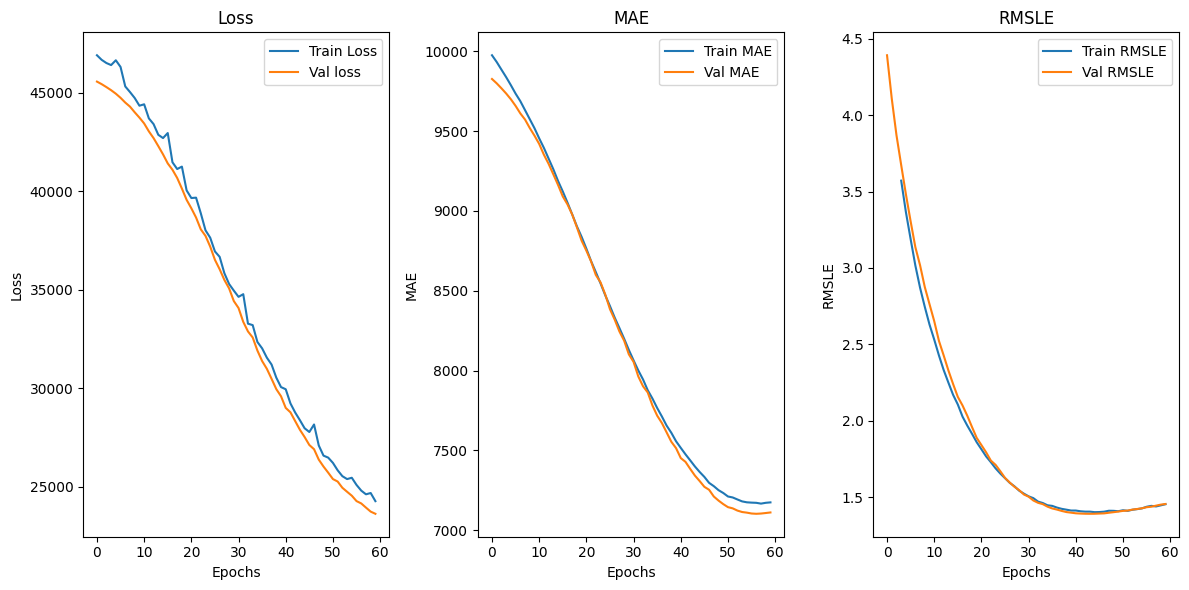

In [31]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(results["Train_MSE"], label="Train Loss")
plt.plot(results["Val_MSE"], label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 3, 2)
plt.plot(results["Train_MAE"], label="Train MAE")
plt.plot(results["Val_MAE"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.title("MAE")

plt.subplot(1, 3, 3)
plt.plot(results["Train_RMSLE"], label="Train RMSLE")
plt.plot(results["Val_RMSLE"], label="Val RMSLE")
plt.xlabel("Epochs")
plt.ylabel("RMSLE")
plt.legend()
plt.title("RMSLE")

plt.tight_layout()
plt.show()

In [51]:
print(f"Final Train RMSLE: {results['Train_RMSLE'][-1]}")
print(f"Final Val RMSLE: {results['Val_RMSLE'][-1]}")

sample = next(iter(train_dataloader))
model_registered(sample[0].to(DEVICE))

Final Train RMSLE: 2.280845744766458
Final Val RMSLE: 2.4980783598763603


tensor([[115.3870],
        [115.8397],
        [129.8604],
        [104.3860],
        [116.0973],
        [128.6425],
        [130.6284],
        [106.7705],
        [111.0017],
        [128.6942],
        [122.4325],
        [119.4029],
        [121.2774],
        [116.5537],
        [138.1857],
        [116.8483],
        [113.5503],
        [109.9210],
        [109.8151],
        [118.8150],
        [121.9067],
        [112.7686],
        [118.8650],
        [130.8477],
        [107.0992],
        [120.4315],
        [110.5188],
        [113.4665],
        [126.1185],
        [110.9732],
        [123.4459],
        [123.3229],
        [103.6981],
        [107.0066],
        [117.2717],
        [108.0546],
        [119.6016],
        [122.7977],
        [112.0527],
        [131.4010],
        [128.1525],
        [110.2971],
        [111.2514],
        [127.5792],
        [120.9147],
        [121.4641],
        [110.3598],
        [122.1324],
        [110.0972],
        [127.0449],


In [48]:
train_dataset = RentalDataset(train_df, "casual")
val_dataset = RentalDataset(val_df, "casual")


model_casual = RentalNet(2, 512, 0.8).to(DEVICE)
optimizer = torch.optim.AdamW(lr=0.000005, params=model_casual.parameters())
criterion = nn.MSELoss()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

results = train(
    model=model_casual,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=60,
    device=DEVICE,
)

  0%|          | 0/60 [00:00<?, ?it/s]

/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mateusz/PW/SSNE/lab/.venv/lib/python3.13/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please

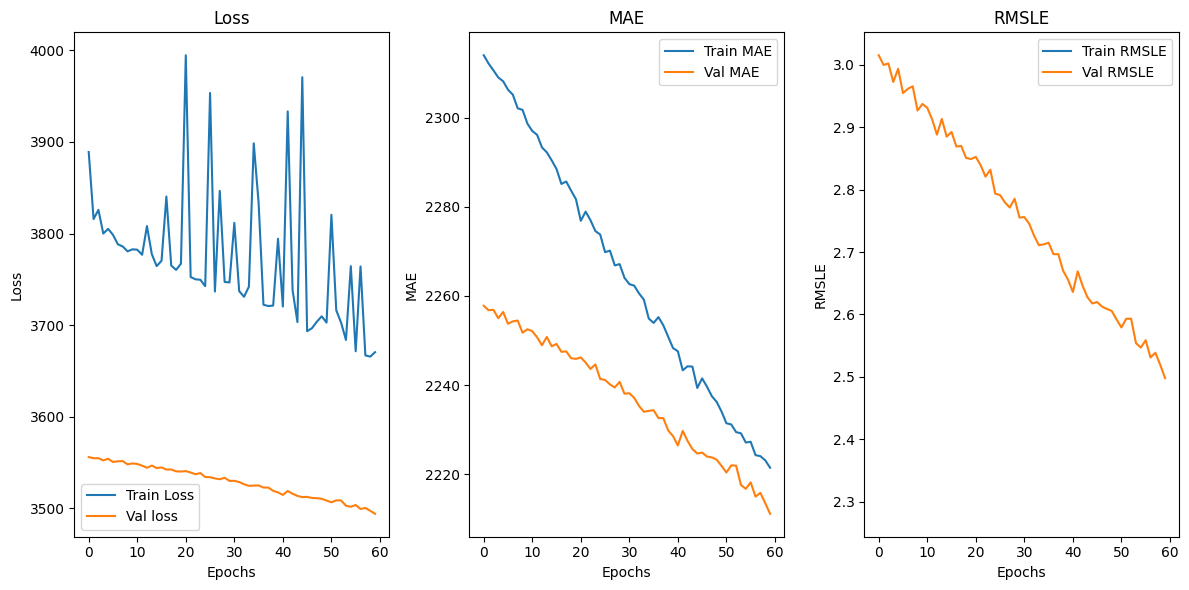

In [49]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(results["Train_MSE"], label="Train Loss")
plt.plot(results["Val_MSE"], label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 3, 2)
plt.plot(results["Train_MAE"], label="Train MAE")
plt.plot(results["Val_MAE"], label="Val MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.title("MAE")

plt.subplot(1, 3, 3)
plt.plot(results["Train_RMSLE"], label="Train RMSLE")
plt.plot(results["Val_RMSLE"], label="Val RMSLE")
plt.xlabel("Epochs")
plt.ylabel("RMSLE")
plt.legend()
plt.title("RMSLE")

plt.tight_layout()
plt.show()

In [55]:
print(f"Final Train RMSLE: {results['Train_RMSLE'][-1]}")
print(f"Final Val RMSLE: {results['Val_RMSLE'][-1]}")
sample = next(iter(train_dataloader))

model_casual(sample[0].to(DEVICE))

Final Train RMSLE: 2.280845744766458
Final Val RMSLE: 2.4980783598763603


tensor([[1.1590],
        [0.9533],
        [1.1509],
        [0.7754],
        [1.1702],
        [0.8639],
        [1.0504],
        [0.8891],
        [0.7232],
        [1.1320],
        [1.0292],
        [0.7834],
        [0.6309],
        [0.8185],
        [0.8737],
        [0.7857],
        [1.0172],
        [0.7537],
        [0.9946],
        [0.8588],
        [0.9640],
        [0.9046],
        [0.9891],
        [0.9739],
        [1.2837],
        [1.0215],
        [1.0185],
        [0.9844],
        [1.1113],
        [1.2607],
        [1.1046],
        [0.9073],
        [1.2474],
        [0.9335],
        [1.1233],
        [0.8514],
        [1.2637],
        [1.0001],
        [0.7097],
        [0.9635],
        [0.8821],
        [0.7794],
        [0.7929],
        [0.8363],
        [0.8873],
        [0.9992],
        [1.0848],
        [1.0056],
        [0.9989],
        [0.9897],
        [1.1912],
        [1.0490],
        [1.0904],
        [0.9434],
        [0.9947],
        [1

In [56]:
test_df = pd.read_csv('evaluation_data.csv')

test_df.head()
test_df = test_df.drop(columns=["dteday"])
test_df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881
1,1,0,1,1,0,4,1,1,0.26,0.2727,0.56,0.0000
2,1,0,1,2,0,4,1,1,0.26,0.2727,0.56,0.0000
3,1,0,1,3,0,4,1,1,0.26,0.2576,0.56,0.1642
4,1,0,1,4,0,4,1,1,0.26,0.2576,0.56,0.1642


In [57]:
class RentalEvalDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.X = df.values
        
    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        return torch.tensor(self.X[index], dtype=torch.float32)
    
    def __len__(self) -> int:
        return len(self.X)

In [58]:
test_dataset = RentalEvalDataset(test_df)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

sample = next(iter(test_loader))
sample[0][0].shape, sample[1][0]

(torch.Size([]), tensor(1.))

In [59]:
preds = []
with torch.inference_mode():
    for X in test_loader:
        X = X.to(DEVICE)
        casual = model_casual(X)
        registered = model_registered(X)
        output = casual + registered
        preds.extend(output.cpu().numpy())


In [60]:
output_df = pd.DataFrame(preds)

In [61]:
output_df.head()
output_df.to_csv("output2.csv", index=False, header=False)